# 手書き数字MNISTの分類AIを作ろう！

MNISTは以下のような感じの手書き数字の画像のデータセットです。0～9の10種類あります。

![alt text](img/MnistExamples.png "Mnist")

本家からダウンロードしてきても良いですが、今回はNumpyのバイナリ用にデータを準備してきていますので、これを使ってください。

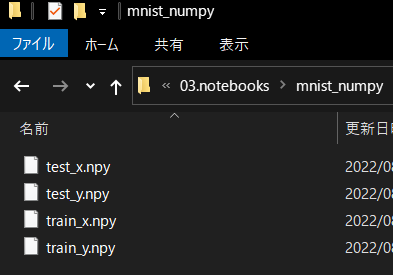

MNISTの公式ページはこちら：
http://yann.lecun.com/exdb/mnist/

# 0. 全体像

以下の手順で進めていこうと思います。

1. ランダムにデータを渡すデータローダ―を作成します。
1. 画像を見て分類を答えるAIモデルをTensorFlowで作成します。
1. 実際に学習をさせてみて、その結果を保存します。
1. 学習済みのパラメータを読み込んで、テスト用画像でテストをさせてみます。

***

# 1. データローダ―を作ろう！

まずは、ランダムにデータ（画像とどの数値かといった値）を渡すデータローダ―という機能を作成していきましょう！

.next()というメソッドが呼ばれるたびにランダムなデータを返してくれる機能を目指します。

まずはデータの確認から始めます。

In [2]:
# データを読み込んでみた
import numpy as np
from PIL import Image

train_x = np.load("mnist_numpy/train_x.npy")
train_y = np.load("mnist_numpy/train_y.npy")
print(train_x.shape, train_y.shape)

(60000, 28, 28) (60000,)


In [3]:
# 6万個の28×28の画像と、その画像の値の種類のデータになっています。
# データの中身はそれぞれどんな感じ？
print(train_x[0])
print(train_y[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

In [4]:
# train_xは28×28の数値の塊なので、数字みただけだとよくわかりません。なので、画像にしてみます。
Image.fromarray(train_x[0])

たしかに数字の「5」になっているようです。数値は0～255の256階層になっていて、0だと黒色、255だと白色です。2の8乗になります。（詳しくは前回の「11.（選択問題）動画の解析.ipynb」）

AIによる学習は、全ての画像を見て一気に学習できればよいのですが、PCのメモリの制約上、ビックデータになればなるほどそういった学習方法は難しいです。そこで、全体のうちから決まった数（バッチサイズといいます）ランダムに選んできて、その数だけ学習をする…ということを繰り返し行うことで、徐々に全体のデータセットについて学習を行っていくという方法で学習をするのが一般的です（バッチ学習と呼ばれます）。

本来であれば、データセットを一通り学習しおわると1エポックの学習が終わったと表現し、数エポック学習しました！などと表記することが一般的です。今回は簡単のため、エポック数の管理は行いませんが、本格的なデータローダ―はエポック数を指定して学習を行うことが可能です。時間に余裕のある方はこのバージョンも作成してみてください。


まずは、6万データから所定のバッチサイズのランダムなデータのペアを返す関数を作成します。

In [6]:
# シンプルなデータローダの作成
class dataset:
    def __init__(self, bs): #bsはバッチサイズ
        self.bs = bs
        self.x = train_x
        self.y = train_y
        self.n = np.arange(len(self.x)) # 6万データのID番号一覧

    def next(self):
        n = np.random.choice(self.n, self.bs) #ID番号一覧からバッチサイズの個数だけランダムに数値をGET
        x = self.x[n] #指定されたID番号のxを取り出す
        y = self.y[n] #指定されたID番号のyを取り出す
        return x,y

d = dataset(64) #バッチサイズが64の場合
x,y = d.next()
print(x.shape, y.shape)

(64, 28, 28) (64,)


In [9]:
# ちなみに　x = self.x[n]　はスライスという表記です。

x = np.array([0.0,1.0,0.0,1.0,0.0])
n = np.array([0,2,4])

print(x[n])
# このように取り出したい番号のところを指定するとその場所の値を取得することができます。

[0. 0. 0.]


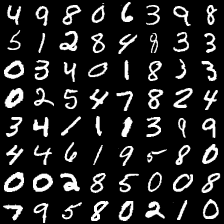

In [10]:
# せっかくなので、取り出された画像がどんな感じか一覧で並べて表示してみるスクリプトも作成しておきます。
# この辺りの記述は、慣れていないとちょっと難しく感じかもしれませんが、気にしないでください。

def npy2img(data, nh=8, nw=8):
    bs,h,w = data.shape
    data = data.reshape([nh,nw,h,w])
    data = data.transpose([0,2,1,3])
    data = data.reshape([nh*h,nw*w])
    return Image.fromarray(data)

x,y = d.next()
npy2img(x)

In [11]:
print(y.reshape([8,8]))

[[4 9 8 0 6 3 9 8]
 [5 1 2 8 4 8 3 3]
 [0 3 4 0 1 8 3 3]
 [0 2 5 4 7 8 2 4]
 [3 4 1 1 1 3 9 9]
 [4 4 6 1 9 5 8 0]
 [0 0 2 8 5 0 0 8]
 [7 9 5 8 0 2 1 0]]


In [12]:
# 画像と数値が矛盾ないことが確認できますね。
# 最後に、AI用のデータは単精度の浮動小数点型で渡す、正規化する、クラスの情報はone hot型にするなど
# 必要なお化粧をする必要があるので、そこだけ反映しておきます。

class dataset:
    def __init__(self, bs): #bsはバッチサイズ
        self.bs = bs
        self.x = train_x
        self.y = train_y
        self.n = np.arange(len(self.x)) # 6万データのID番号一覧

    def next(self):
        n = np.random.choice(self.n, self.bs) #ID番号一覧からバッチサイズの個数だけランダムに数値をGET
        x = self.x[n] #指定されたID番号のxを取り出す
        y = self.y[n] #指定されたID番号のyを取り出す

        #### お化粧
        x = x[:,:,:,np.newaxis] #[bs,h,w,ch]の形に変換
        x = x.astype(np.float32)/255 #xを単精度浮動小数点型に変換
        y = np.eye(10)[y] #yをone-hot型に変換
        y = y.astype(np.float32) #yも単精度浮動小数点型に変換
        return x,y

d = dataset(64)
x,y = d.next()
print(x.shape, y.shape)

(64, 28, 28, 1) (64, 10)


***

# 2. AIモデルを作ろう！

次にTensorFlowでAIモデルを定義していきます。

In [19]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL']='2' #おまじないです。きにしないで。

inputs = tf.keras.Input(shape=(28,28,1))
x = tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2,2))(inputs) #(14,14,64)
print(x.shape)
x = tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2,2))(x)      #(7,7,64)
print(x.shape)
x = tf.keras.layers.Flatten()(x)                                     #(7*7*64)
print(x.shape)
outputs = tf.keras.layers.Dense(10)(x)                               #(10)
print(outputs.shape)

model= tf.keras.Model(inputs=inputs, outputs=outputs)

(None, 13, 13, 64)
(None, 6, 6, 64)
(None, 2304)
(None, 10)


この辺りの書き方はTensorflowというGoogle（DeepMind）の提供しているライブラリの仕様に沿って記述することになります。  
簡単に説明すると「Conv2D」というのが畳み込みニューラルネットワークと呼ばれるもので、画像解析のフィルタ操作をしているものです。  
「Dense」とあるのが全結合層で、普通のニューラルネットワークのことです。  
「Flatten」は畳み込みの結果を全結合に渡せるように

興味がある方はググってみてください！

In [21]:
# この辺りも完全にTensorflowの仕様なので、こうゆうものなのだなとご理解ください。

opt = tf.keras.optimizers.Adam(learning_rate=1e-4) #オプティマイザと呼ばれる学習を行う機能

#@tf.function() #早くなるおまじない
def train_step(x, y): #学習ステップ
    with tf.GradientTape() as tape: #勾配の計測をはじめる合図（呪文）
        yp = model(x) #推論してみる
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=yp) #答え合わせ
        loss = tf.reduce_mean(loss) #平均しました。
    _vars = model.trainable_variables #更新したいパラメータを列挙
    grads = tape.gradient(loss, _vars) #勾配を計算
    opt.apply_gradients(zip(grads, _vars)) #勾配情報を基にパラメータを更新
    return loss #損失を返します。

***

# 3. 学習スタート！

In [22]:
# 2000ステップくらい学習させようかな
for n in range(2000): #適当な回数ループ
    x,y = d.next() #ランダムにデータを生成
    loss = train_step(x,y) #学習！
    if (n+1)%10 == 0: print(n+1, loss.numpy())

10 2.266437
20 2.2156048
30 2.1775732
40 2.080462
50 2.0517445
60 1.9124317
70 1.8907228
80 1.7585279
90 1.5358558
100 1.4704926
110 1.392764
120 1.2466214
130 1.0625472
140 0.9447733
150 0.9725473
160 0.80578417
170 0.7490754
180 0.7015128
190 0.7371323
200 0.67644864
210 0.4628688
220 0.4916064
230 0.48440945
240 0.59877706
250 0.47153378
260 0.49910086
270 0.53171057
280 0.4113466
290 0.4511356
300 0.36655504
310 0.33112836
320 0.40576205
330 0.5524686
340 0.40751958
350 0.49637234
360 0.40978143
370 0.48199606
380 0.410603
390 0.37421167
400 0.50982547
410 0.6174581
420 0.5773996
430 0.383345
440 0.2444306
450 0.3461956
460 0.36699408
470 0.38820475
480 0.3684181
490 0.53884965
500 0.5102004
510 0.5472782
520 0.4933485
530 0.4811739
540 0.31141108
550 0.30978805
560 0.29385245
570 0.3611608
580 0.42106766
590 0.35629877
600 0.43016756
610 0.42949226
620 0.27960676
630 0.2412349
640 0.25306392
650 0.5392606
660 0.477842
670 0.38181236
680 0.20790046
690 0.24778378
700 0.24692193
710

In [23]:
# 外部に保存しておきます！
model.save_weights("model.h5")

***

# 4. 推論させてみよう！

学習に使わずにとっておいた「mnist_numpy/test_x.npy」「mnist_numpy/test_y.npy」を使って推論してみましょう！

In [24]:
test_x = np.load("mnist_numpy/test_x.npy")
test_y = np.load("mnist_numpy/test_y.npy")
print(test_x.shape, test_y.shape)

(10000, 28, 28) (10000,)


In [31]:
# モデルに入れるには、学習時と同じお化粧が必要です。

test_x = np.load("mnist_numpy/test_x.npy")
test_y = np.load("mnist_numpy/test_y.npy")
print(test_x.shape, test_y.shape)

test_x = test_x[:,:,:,np.newaxis]
test_x = test_x.astype(np.float32)/255

#model.load_weights("model.h5") #読み込み
for x,y in zip(test_x,test_y):
    #print(x.shape)
    y_ = model(x[np.newaxis])
    #print(y_.numpy())
    print("予測は", np.argmax(y_.numpy()[0]), ", 正解は", y)
    #break


(10000, 28, 28) (10000,)
予測は 7 , 正解は 7
予測は 2 , 正解は 2
予測は 1 , 正解は 1
予測は 0 , 正解は 0
予測は 4 , 正解は 4
予測は 1 , 正解は 1
予測は 4 , 正解は 4
予測は 9 , 正解は 9
予測は 6 , 正解は 5
予測は 9 , 正解は 9
予測は 0 , 正解は 0
予測は 6 , 正解は 6
予測は 9 , 正解は 9
予測は 0 , 正解は 0
予測は 1 , 正解は 1
予測は 5 , 正解は 5
予測は 9 , 正解は 9
予測は 7 , 正解は 7
予測は 3 , 正解は 3
予測は 4 , 正解は 4
予測は 9 , 正解は 9
予測は 6 , 正解は 6
予測は 6 , 正解は 6
予測は 5 , 正解は 5
予測は 4 , 正解は 4
予測は 0 , 正解は 0
予測は 7 , 正解は 7
予測は 4 , 正解は 4
予測は 0 , 正解は 0
予測は 1 , 正解は 1
予測は 3 , 正解は 3
予測は 1 , 正解は 1
予測は 3 , 正解は 3
予測は 0 , 正解は 4
予測は 7 , 正解は 7
予測は 2 , 正解は 2
予測は 7 , 正解は 7
予測は 1 , 正解は 1
予測は 2 , 正解は 2
予測は 1 , 正解は 1
予測は 1 , 正解は 1
予測は 7 , 正解は 7
予測は 4 , 正解は 4
予測は 2 , 正解は 2
予測は 3 , 正解は 3
予測は 5 , 正解は 5
予測は 1 , 正解は 1
予測は 2 , 正解は 2
予測は 4 , 正解は 4
予測は 4 , 正解は 4
予測は 6 , 正解は 6
予測は 3 , 正解は 3
予測は 5 , 正解は 5
予測は 5 , 正解は 5
予測は 6 , 正解は 6
予測は 0 , 正解は 0
予測は 4 , 正解は 4
予測は 1 , 正解は 1
予測は 9 , 正解は 9
予測は 5 , 正解は 5
予測は 7 , 正解は 7
予測は 8 , 正解は 8
予測は 9 , 正解は 9
予測は 2 , 正解は 3
予測は 7 , 正解は 7
予測は 4 , 正解は 4
予測は 2 , 正解は 6
予測は 4 , 正解は 4
予測は 3 , 正解は 3
予測は 0 , 正

予測は 5 , 正解は 5
予測は 1 , 正解は 1
予測は 1 , 正解は 1
予測は 4 , 正解は 4
予測は 9 , 正解は 4
予測は 3 , 正解は 3
予測は 1 , 正解は 1
予測は 0 , 正解は 0
予測は 7 , 正解は 7
予測は 7 , 正解は 7
予測は 0 , 正解は 0
予測は 7 , 正解は 7
予測は 9 , 正解は 9
予測は 9 , 正解は 4
予測は 4 , 正解は 4
予測は 8 , 正解は 8
予測は 5 , 正解は 5
予測は 5 , 正解は 5
予測は 4 , 正解は 4
予測は 0 , 正解は 0
予測は 5 , 正解は 8
予測は 2 , 正解は 2
予測は 1 , 正解は 1
予測は 6 , 正解は 0
予測は 8 , 正解は 8
予測は 4 , 正解は 4
予測は 2 , 正解は 5
予測は 0 , 正解は 0
予測は 4 , 正解は 4
予測は 0 , 正解は 0
予測は 6 , 正解は 6
予測は 1 , 正解は 1
予測は 7 , 正解は 7
予測は 3 , 正解は 3
予測は 8 , 正解は 2
予測は 6 , 正解は 6
予測は 7 , 正解は 7
予測は 2 , 正解は 2
予測は 6 , 正解は 6
予測は 9 , 正解は 9
予測は 5 , 正解は 3
予測は 1 , 正解は 1
予測は 4 , 正解は 4
予測は 6 , 正解は 6
予測は 2 , 正解は 2
予測は 5 , 正解は 5
予測は 9 , 正解は 4
予測は 2 , 正解は 2
予測は 0 , 正解は 0
予測は 6 , 正解は 6
予測は 2 , 正解は 2
予測は 1 , 正解は 1
予測は 7 , 正解は 7
予測は 3 , 正解は 3
予測は 9 , 正解は 4
予測は 1 , 正解は 1
予測は 0 , 正解は 0
予測は 5 , 正解は 5
予測は 4 , 正解は 4
予測は 3 , 正解は 3
予測は 1 , 正解は 1
予測は 1 , 正解は 1
予測は 7 , 正解は 7
予測は 4 , 正解は 4
予測は 9 , 正解は 9
予測は 9 , 正解は 9
予測は 9 , 正解は 4
予測は 8 , 正解は 8
予測は 4 , 正解は 4
予測は 0 , 正解は 0
予測は 2 , 正解は 2
予測は 4 

予測は 6 , 正解は 6
予測は 5 , 正解は 5
予測は 7 , 正解は 7
予測は 6 , 正解は 6
予測は 3 , 正解は 3
予測は 3 , 正解は 3
予測は 9 , 正解は 9
予測は 6 , 正解は 6
予測は 1 , 正解は 1
予測は 1 , 正解は 1
予測は 2 , 正解は 2
予測は 9 , 正解は 9
予測は 0 , 正解は 0
予測は 4 , 正解は 4
予測は 3 , 正解は 3
予測は 3 , 正解は 3
予測は 6 , 正解は 6
予測は 9 , 正解は 9
予測は 5 , 正解は 5
予測は 9 , 正解は 7
予測は 3 , 正解は 3
予測は 7 , 正解は 7
予測は 7 , 正解は 7
予測は 7 , 正解は 7
予測は 8 , 正解は 8
予測は 1 , 正解は 7
予測は 9 , 正解は 9
予測は 8 , 正解は 8
予測は 3 , 正解は 3
予測は 0 , 正解は 0
予測は 7 , 正解は 7
予測は 2 , 正解は 2
予測は 7 , 正解は 7
予測は 9 , 正解は 9
予測は 4 , 正解は 4
予測は 5 , 正解は 5
予測は 4 , 正解は 4
予測は 9 , 正解は 9
予測は 3 , 正解は 3
予測は 8 , 正解は 2
予測は 1 , 正解は 1
予測は 4 , 正解は 4
予測は 0 , 正解は 0
予測は 2 , 正解は 2
予測は 3 , 正解は 3
予測は 7 , 正解は 7
予測は 5 , 正解は 5
予測は 9 , 正解は 7
予測は 8 , 正解は 8
予測は 8 , 正解は 8
予測は 0 , 正解は 5
予測は 0 , 正解は 0
予測は 6 , 正解は 1
予測は 1 , 正解は 1
予測は 4 , 正解は 4
予測は 7 , 正解は 8
予測は 3 , 正解は 3
予測は 9 , 正解は 9
予測は 0 , 正解は 0
予測は 0 , 正解は 0
予測は 0 , 正解は 0
予測は 6 , 正解は 6
予測は 6 , 正解は 6
予測は 2 , 正解は 2
予測は 3 , 正解は 3
予測は 7 , 正解は 7
予測は 8 , 正解は 8
予測は 4 , 正解は 4
予測は 7 , 正解は 7
予測は 7 , 正解は 7
予測は 9 , 正解は 9
予測は 2 

予測は 1 , 正解は 1
予測は 3 , 正解は 3
予測は 0 , 正解は 0
予測は 8 , 正解は 3
予測は 4 , 正解は 4
予測は 4 , 正解は 4
予測は 3 , 正解は 3
予測は 8 , 正解は 8
予測は 9 , 正解は 9
予測は 2 , 正解は 2
予測は 5 , 正解は 3
予測は 9 , 正解は 9
予測は 7 , 正解は 7
予測は 1 , 正解は 1
予測は 1 , 正解は 1
予測は 7 , 正解は 7
予測は 0 , 正解は 0
予測は 4 , 正解は 4
予測は 5 , 正解は 9
予測は 6 , 正解は 6
予測は 5 , 正解は 5
予測は 9 , 正解は 9
予測は 1 , 正解は 1
予測は 2 , 正解は 7
予測は 0 , 正解は 0
予測は 2 , 正解は 2
予測は 0 , 正解は 0
予測は 0 , 正解は 0
予測は 4 , 正解は 4
予測は 6 , 正解は 6
予測は 7 , 正解は 7
予測は 0 , 正解は 0
予測は 7 , 正解は 7
予測は 1 , 正解は 1
予測は 4 , 正解は 4
予測は 6 , 正解は 6
予測は 4 , 正解は 4
予測は 5 , 正解は 5
予測は 4 , 正解は 4
予測は 9 , 正解は 9
予測は 9 , 正解は 9
予測は 1 , 正解は 1
予測は 7 , 正解は 7
予測は 9 , 正解は 9
予測は 5 , 正解は 5
予測は 3 , 正解は 3
予測は 3 , 正解は 3
予測は 8 , 正解は 8
予測は 2 , 正解は 2
予測は 0 , 正解は 3
予測は 6 , 正解は 6
予測は 2 , 正解は 2
予測は 2 , 正解は 2
予測は 1 , 正解は 1
予測は 1 , 正解は 1
予測は 1 , 正解は 1
予測は 1 , 正解は 1
予測は 1 , 正解は 1
予測は 6 , 正解は 6
予測は 9 , 正解は 9
予測は 8 , 正解は 8
予測は 4 , 正解は 4
予測は 3 , 正解は 3
予測は 7 , 正解は 7
予測は 1 , 正解は 1
予測は 6 , 正解は 6
予測は 4 , 正解は 4
予測は 9 , 正解は 5
予測は 0 , 正解は 0
予測は 9 , 正解は 4
予測は 7 , 正解は 7
予測は 4 

予測は 4 , 正解は 4
予測は 4 , 正解は 4
予測は 1 , 正解は 1
予測は 5 , 正解は 5
予測は 2 , 正解は 2
予測は 8 , 正解は 8
予測は 5 , 正解は 3
予測は 9 , 正解は 4
予測は 9 , 正解は 9
予測は 5 , 正解は 5
予測は 2 , 正解は 2
予測は 8 , 正解は 8
予測は 1 , 正解は 1
予測は 5 , 正解は 5
予測は 8 , 正解は 3
予測は 7 , 正解は 7
予測は 9 , 正解は 9
予測は 4 , 正解は 4
予測は 2 , 正解は 2
予測は 2 , 正解は 5
予測は 6 , 正解は 6
予測は 0 , 正解は 3
予測は 5 , 正解は 5
予測は 9 , 正解は 9
予測は 3 , 正解は 3
予測は 0 , 正解は 5
予測は 9 , 正解は 9
予測は 2 , 正解は 3
予測は 1 , 正解は 1
予測は 9 , 正解は 9
予測は 5 , 正解は 5
予測は 3 , 正解は 3
予測は 0 , 正解は 0
予測は 6 , 正解は 6
予測は 9 , 正解は 9
予測は 8 , 正解は 8
予測は 4 , 正解は 4
予測は 0 , 正解は 0
予測は 4 , 正解は 4
予測は 9 , 正解は 9
予測は 2 , 正解は 2
予測は 9 , 正解は 9
予測は 0 , 正解は 0
予測は 1 , 正解は 1
予測は 0 , 正解は 0
予測は 7 , 正解は 3
予測は 1 , 正解は 1
予測は 6 , 正解は 6
予測は 5 , 正解は 5
予測は 8 , 正解は 8
予測は 1 , 正解は 1
予測は 5 , 正解は 5
予測は 3 , 正解は 3
予測は 5 , 正解は 3
予測は 0 , 正解は 0
予測は 3 , 正解は 3
予測は 5 , 正解は 5
予測は 5 , 正解は 5
予測は 9 , 正解は 9
予測は 2 , 正解は 2
予測は 8 , 正解は 8
予測は 7 , 正解は 7
予測は 0 , 正解は 0
予測は 4 , 正解は 4
予測は 9 , 正解は 9
予測は 1 , 正解は 1
予測は 9 , 正解は 9
予測は 7 , 正解は 7
予測は 7 , 正解は 7
予測は 5 , 正解は 5
予測は 7 , 正解は 5
予測は 2 

予測は 9 , 正解は 4
予測は 7 , 正解は 7
予測は 7 , 正解は 7
予測は 7 , 正解は 7
予測は 4 , 正解は 4
予測は 9 , 正解は 9
予測は 0 , 正解は 0
予測は 6 , 正解は 6
予測は 9 , 正解は 4
予測は 8 , 正解は 8
予測は 4 , 正解は 4
予測は 2 , 正解は 2
予測は 9 , 正解は 7
予測は 2 , 正解は 2
予測は 1 , 正解は 8
予測は 1 , 正解は 1
予測は 0 , 正解は 0
予測は 0 , 正解は 0
予測は 7 , 正解は 7
予測は 8 , 正解は 8
予測は 3 , 正解は 3
予測は 3 , 正解は 3
予測は 3 , 正解は 3
予測は 1 , 正解は 1
予測は 3 , 正解は 3
予測は 7 , 正解は 7
予測は 6 , 正解は 6
予測は 1 , 正解は 1
予測は 3 , 正解は 3
予測は 1 , 正解は 1
予測は 6 , 正解は 6
予測は 0 , 正解は 6
予測は 5 , 正解は 5
予測は 7 , 正解は 7
予測は 4 , 正解は 4
予測は 7 , 正解は 7
予測は 5 , 正解は 5
予測は 9 , 正解は 9
予測は 5 , 正解は 5
予測は 3 , 正解は 8
予測は 9 , 正解は 4
予測は 9 , 正解は 9
予測は 9 , 正解は 9
予測は 1 , 正解は 1
予測は 6 , 正解は 6
予測は 4 , 正解は 5
予測は 0 , 正解は 0
予測は 1 , 正解は 1
予測は 3 , 正解は 3
予測は 2 , 正解は 7
予測は 0 , 正解は 0
予測は 9 , 正解は 3
予測は 4 , 正解は 4
予測は 8 , 正解は 8
予測は 2 , 正解は 2
予測は 2 , 正解は 2
予測は 0 , 正解は 0
予測は 2 , 正解は 2
予測は 8 , 正解は 5
予測は 1 , 正解は 1
予測は 5 , 正解は 5
予測は 1 , 正解は 1
予測は 6 , 正解は 4
予測は 8 , 正解は 8
予測は 8 , 正解は 8
予測は 9 , 正解は 9
予測は 1 , 正解は 1
予測は 2 , 正解は 2
予測は 1 , 正解は 1
予測は 3 , 正解は 3
予測は 5 , 正解は 5
予測は 1 

予測は 6 , 正解は 6
予測は 1 , 正解は 9
予測は 3 , 正解は 3
予測は 9 , 正解は 9
予測は 2 , 正解は 2
予測は 2 , 正解は 2
予測は 9 , 正解は 9
予測は 2 , 正解は 2
予測は 1 , 正解は 1
予測は 8 , 正解は 8
予測は 3 , 正解は 3
予測は 2 , 正解は 2
予測は 9 , 正解は 9
予測は 6 , 正解は 6
予測は 8 , 正解は 8
予測は 4 , 正解は 4
予測は 0 , 正解は 0
予測は 1 , 正解は 1
予測は 2 , 正解は 2
予測は 8 , 正解は 8
予測は 4 , 正解は 4
予測は 5 , 正解は 5
予測は 2 , 正解は 2
予測は 7 , 正解は 7
予測は 3 , 正解は 8
予測は 1 , 正解は 1
予測は 1 , 正解は 1
予測は 3 , 正解は 3
予測は 0 , 正解は 0
予測は 3 , 正解は 3
予測は 5 , 正解は 5
予測は 7 , 正解は 7
予測は 0 , 正解は 0
予測は 3 , 正解は 3
予測は 1 , 正解は 1
予測は 9 , 正解は 9
予測は 3 , 正解は 3
予測は 6 , 正解は 6
予測は 3 , 正解は 3
予測は 1 , 正解は 1
予測は 7 , 正解は 7
予測は 9 , 正解は 7
予測は 3 , 正解は 3
予測は 0 , 正解は 0
予測は 8 , 正解は 8
予測は 4 , 正解は 4
予測は 8 , 正解は 8
予測は 2 , 正解は 2
予測は 6 , 正解は 6
予測は 0 , 正解は 5
予測は 2 , 正解は 2
予測は 9 , 正解は 9
予測は 7 , 正解は 7
予測は 3 , 正解は 3
予測は 9 , 正解は 9
予測は 0 , 正解は 0
予測は 9 , 正解は 9
予測は 9 , 正解は 9
予測は 6 , 正解は 6
予測は 4 , 正解は 4
予測は 2 , 正解は 2
予測は 9 , 正解は 9
予測は 7 , 正解は 7
予測は 2 , 正解は 2
予測は 1 , 正解は 1
予測は 1 , 正解は 1
予測は 6 , 正解は 6
予測は 7 , 正解は 7
予測は 9 , 正解は 4
予測は 7 , 正解は 7
予測は 5 , 正解は 5
予測は 9 

予測は 7 , 正解は 7
予測は 0 , 正解は 8
予測は 9 , 正解は 9
予測は 8 , 正解は 8
予測は 0 , 正解は 0
予測は 5 , 正解は 5
予測は 6 , 正解は 6
予測は 6 , 正解は 6
予測は 0 , 正解は 0
予測は 8 , 正解は 8
予測は 0 , 正解は 0
予測は 2 , 正解は 2
予測は 3 , 正解は 3
予測は 7 , 正解は 7
予測は 9 , 正解は 9
予測は 4 , 正解は 4
予測は 7 , 正解は 7
予測は 1 , 正解は 1
予測は 9 , 正解は 9
予測は 1 , 正解は 1
予測は 7 , 正解は 7
予測は 1 , 正解は 1
予測は 4 , 正解は 4
予測は 0 , 正解は 0
予測は 0 , 正解は 0
予測は 4 , 正解は 4
予測は 1 , 正解は 1
予測は 7 , 正解は 7
予測は 5 , 正解は 5
予測は 7 , 正解は 7
予測は 1 , 正解は 1
予測は 3 , 正解は 3
予測は 3 , 正解は 3
予測は 3 , 正解は 3
予測は 6 , 正解は 1
予測は 6 , 正解は 6
予測は 9 , 正解は 9
予測は 7 , 正解は 7
予測は 4 , 正解は 4
予測は 3 , 正解は 3
予測は 0 , 正解は 0
予測は 2 , 正解は 2
予測は 5 , 正解は 5
予測は 2 , 正解は 2
予測は 6 , 正解は 6
予測は 0 , 正解は 0
予測は 8 , 正解は 8
予測は 9 , 正解は 9
予測は 4 , 正解は 4
予測は 3 , 正解は 3
予測は 5 , 正解は 5
予測は 4 , 正解は 4
予測は 8 , 正解は 8
予測は 1 , 正解は 1
予測は 5 , 正解は 5
予測は 9 , 正解は 9
予測は 0 , 正解は 0
予測は 6 , 正解は 6
予測は 4 , 正解は 4
予測は 3 , 正解は 3
予測は 6 , 正解は 6
予測は 3 , 正解は 3
予測は 3 , 正解は 3
予測は 8 , 正解は 8
予測は 1 , 正解は 1
予測は 4 , 正解は 4
予測は 7 , 正解は 7
予測は 5 , 正解は 5
予測は 7 , 正解は 7
予測は 2 , 正解は 2
予測は 2 , 正解は 2
予測は 0 

予測は 7 , 正解は 7
予測は 8 , 正解は 8
予測は 9 , 正解は 4
予測は 6 , 正解は 6
予測は 4 , 正解は 4
予測は 9 , 正解は 9
予測は 5 , 正解は 3
予測は 8 , 正解は 8
予測は 4 , 正解は 4
予測は 7 , 正解は 7
予測は 2 , 正解は 2
予測は 5 , 正解は 5
予測は 6 , 正解は 6
予測は 8 , 正解は 3
予測は 6 , 正解は 6
予測は 9 , 正解は 9
予測は 6 , 正解は 6
予測は 8 , 正解は 3
予測は 5 , 正解は 2
予測は 2 , 正解は 2
予測は 9 , 正解は 4
予測は 6 , 正解は 6
予測は 9 , 正解は 9
予測は 0 , 正解は 0
予測は 2 , 正解は 2
予測は 8 , 正解は 5
予測は 8 , 正解は 5
予測は 1 , 正解は 1
予測は 8 , 正解は 3
予測は 3 , 正解は 3
予測は 9 , 正解は 9
予測は 7 , 正解は 7
予測は 8 , 正解は 8
予測は 7 , 正解は 7
予測は 2 , 正解は 2
予測は 2 , 正解は 2
予測は 5 , 正解は 5
予測は 7 , 正解は 7
予測は 9 , 正解は 9
予測は 8 , 正解は 8
予測は 2 , 正解は 2
予測は 1 , 正解は 1
予測は 8 , 正解は 3
予測は 1 , 正解は 1
予測は 3 , 正解は 3
予測は 0 , 正解は 0
予測は 1 , 正解は 1
予測は 2 , 正解は 2
予測は 8 , 正解は 3
予測は 4 , 正解は 4
予測は 5 , 正解は 5
予測は 6 , 正解は 6
予測は 7 , 正解は 7
予測は 8 , 正解は 8
予測は 3 , 正解は 9
予測は 0 , 正解は 0
予測は 1 , 正解は 1
予測は 2 , 正解は 2
予測は 3 , 正解は 3
予測は 4 , 正解は 4
予測は 5 , 正解は 5
予測は 6 , 正解は 6
予測は 7 , 正解は 7
予測は 8 , 正解は 8
予測は 8 , 正解は 9
予測は 0 , 正解は 0
予測は 1 , 正解は 1
予測は 2 , 正解は 2
予測は 3 , 正解は 3
予測は 4 , 正解は 4
予測は 5 , 正解は 5
予測は 6 

予測は 1 , 正解は 1
予測は 2 , 正解は 2
予測は 3 , 正解は 3
予測は 4 , 正解は 4
予測は 5 , 正解は 5
予測は 6 , 正解は 6
予測は 7 , 正解は 7
予測は 8 , 正解は 8
予測は 9 , 正解は 9
予測は 0 , 正解は 0
予測は 1 , 正解は 1
予測は 2 , 正解は 2
予測は 3 , 正解は 3
予測は 4 , 正解は 4
予測は 5 , 正解は 5
予測は 6 , 正解は 6
予測は 9 , 正解は 9
予測は 0 , 正解は 0
予測は 1 , 正解は 1
予測は 4 , 正解は 2
予測は 3 , 正解は 3
予測は 4 , 正解は 4
予測は 7 , 正解は 7
予測は 8 , 正解は 8
予測は 1 , 正解は 1
予測は 3 , 正解は 3
予測は 5 , 正解は 5
予測は 1 , 正解は 1
予測は 7 , 正解は 7
予測は 7 , 正解は 7
予測は 2 , 正解は 2
予測は 1 , 正解は 1
予測は 4 , 正解は 4
予測は 8 , 正解は 8
予測は 3 , 正解は 3
予測は 4 , 正解は 4
予測は 4 , 正解は 4
予測は 2 , 正解は 3
予測は 0 , 正解は 9
予測は 7 , 正解は 7
予測は 4 , 正解は 4
予測は 1 , 正解は 1
予測は 8 , 正解は 2
予測は 3 , 正解は 3
予測は 4 , 正解は 5
予測は 9 , 正解は 9
予測は 1 , 正解は 1
予測は 6 , 正解は 6
予測は 0 , 正解は 0
予測は 1 , 正解は 1
予測は 0 , 正解は 0
予測は 0 , 正解は 0
予測は 2 , 正解は 2
予測は 8 , 正解は 8
予測は 7 , 正解は 7
予測は 1 , 正解は 1
予測は 1 , 正解は 1
予測は 4 , 正解は 4
予測は 0 , 正解は 0
予測は 4 , 正解は 4
予測は 7 , 正解は 7
予測は 3 , 正解は 3
予測は 6 , 正解は 6
予測は 8 , 正解は 8
予測は 0 , 正解は 0
予測は 3 , 正解は 3
予測は 2 , 正解は 7
予測は 8 , 正解は 4
予測は 0 , 正解は 0
予測は 6 , 正解は 6
予測は 9 , 正解は 9
予測は 2 

予測は 5 , 正解は 5
予測は 6 , 正解は 6
予測は 7 , 正解は 7
予測は 0 , 正解は 0
予測は 6 , 正解は 6
予測は 1 , 正解は 1
予測は 6 , 正解は 6
予測は 8 , 正解は 8
予測は 7 , 正解は 7
予測は 0 , 正解は 0
予測は 1 , 正解は 1
予測は 5 , 正解は 5
予測は 0 , 正解は 0
予測は 8 , 正解は 8
予測は 6 , 正解は 5
予測は 0 , 正解は 0
予測は 1 , 正解は 1
予測は 5 , 正解は 5
予測は 8 , 正解は 8
予測は 4 , 正解は 4
予測は 2 , 正解は 2
予測は 3 , 正解は 3
予測は 5 , 正解は 9
予測は 7 , 正解は 7
予測は 6 , 正解は 6
予測は 9 , 正解は 9
予測は 1 , 正解は 1
予測は 9 , 正解は 9
予測は 0 , 正解は 0
予測は 6 , 正解は 6
予測は 7 , 正解は 7
予測は 1 , 正解は 1
予測は 2 , 正解は 2
予測は 3 , 正解は 3
予測は 9 , 正解は 9
予測は 2 , 正解は 2
予測は 8 , 正解は 4
予測は 5 , 正解は 5
予測は 5 , 正解は 5
予測は 3 , 正解は 3
予測は 7 , 正解は 7
予測は 5 , 正解は 5
予測は 3 , 正解は 3
予測は 1 , 正解は 1
予測は 8 , 正解は 8
予測は 2 , 正解は 2
予測は 2 , 正解は 2
予測は 3 , 正解は 3
予測は 0 , 正解は 0
予測は 2 , 正解は 2
予測は 9 , 正解は 9
予測は 4 , 正解は 4
予測は 9 , 正解は 9
予測は 7 , 正解は 7
予測は 0 , 正解は 0
予測は 7 , 正解は 2
予測は 7 , 正解は 7
予測は 5 , 正解は 4
予測は 9 , 正解は 9
予測は 9 , 正解は 9
予測は 2 , 正解は 2
予測は 3 , 正解は 5
予測は 9 , 正解は 9
予測は 8 , 正解は 8
予測は 3 , 正解は 3
予測は 8 , 正解は 8
予測は 6 , 正解は 6
予測は 7 , 正解は 7
予測は 0 , 正解は 0
予測は 0 , 正解は 0
予測は 1 , 正解は 1
予測は 2 

予測は 8 , 正解は 8
予測は 5 , 正解は 5
予測は 1 , 正解は 1
予測は 5 , 正解は 5
予測は 2 , 正解は 2
予測は 3 , 正解は 3
予測は 0 , 正解は 0
予測は 1 , 正解は 1
予測は 4 , 正解は 2
予測は 1 , 正解は 1
予測は 3 , 正解は 3
予測は 2 , 正解は 2
予測は 6 , 正解は 6
予測は 5 , 正解は 5
予測は 3 , 正解は 3
予測は 0 , 正解は 0
予測は 7 , 正解は 7
予測は 2 , 正解は 2
予測は 7 , 正解は 7
予測は 4 , 正解は 4
予測は 6 , 正解は 6
予測は 4 , 正解は 4
予測は 0 , 正解は 0
予測は 5 , 正解は 5
予測は 9 , 正解は 9
予測は 9 , 正解は 9
予測は 5 , 正解は 8
予測は 9 , 正解は 9
予測は 5 , 正解は 5
予測は 3 , 正解は 3
予測は 1 , 正解は 1
予測は 7 , 正解は 7
予測は 4 , 正解は 4
予測は 7 , 正解は 7
予測は 6 , 正解は 6
予測は 5 , 正解は 5
予測は 4 , 正解は 4
予測は 0 , 正解は 0
予測は 0 , 正解は 0
予測は 0 , 正解は 6
予測は 6 , 正解は 6
予測は 2 , 正解は 2
予測は 0 , 正解は 0
予測は 6 , 正解は 6
予測は 3 , 正解は 3
予測は 7 , 正解は 7
予測は 7 , 正解は 7
予測は 4 , 正解は 4
予測は 4 , 正解は 4
予測は 3 , 正解は 3
予測は 9 , 正解は 9
予測は 2 , 正解は 2
予測は 8 , 正解は 8
予測は 9 , 正解は 9
予測は 6 , 正解は 6
予測は 0 , 正解は 0
予測は 9 , 正解は 9
予測は 5 , 正解は 5
予測は 3 , 正解は 3
予測は 8 , 正解は 8
予測は 8 , 正解は 8
予測は 7 , 正解は 7
予測は 1 , 正解は 1
予測は 4 , 正解は 4
予測は 0 , 正解は 0
予測は 4 , 正解は 4
予測は 8 , 正解は 8
予測は 5 , 正解は 5
予測は 2 , 正解は 2
予測は 3 , 正解は 3
予測は 9 , 正解は 9
予測は 0 

予測は 1 , 正解は 1
予測は 7 , 正解は 7
予測は 1 , 正解は 1
予測は 3 , 正解は 3
予測は 8 , 正解は 8
予測は 5 , 正解は 5
予測は 4 , 正解は 4
予測は 2 , 正解は 2
予測は 0 , 正解は 0
予測は 9 , 正解は 9
予測は 7 , 正解は 7
予測は 6 , 正解は 6
予測は 7 , 正解は 7
予測は 4 , 正解は 4
予測は 1 , 正解は 1
予測は 6 , 正解は 6
予測は 2 , 正解は 2
予測は 6 , 正解は 6
予測は 7 , 正解は 7
予測は 1 , 正解は 1
予測は 9 , 正解は 9
予測は 8 , 正解は 8
予測は 0 , 正解は 0
予測は 6 , 正解は 6
予測は 9 , 正解は 9
予測は 4 , 正解は 4
予測は 9 , 正解は 9
予測は 9 , 正解は 9
予測は 6 , 正解は 6
予測は 2 , 正解は 2
予測は 3 , 正解は 3
予測は 7 , 正解は 7
予測は 1 , 正解は 1
予測は 9 , 正解は 9
予測は 2 , 正解は 2
予測は 2 , 正解は 2
予測は 5 , 正解は 5
予測は 3 , 正解は 3
予測は 7 , 正解は 7
予測は 8 , 正解は 8
予測は 0 , 正解は 0
予測は 1 , 正解は 1
予測は 2 , 正解は 2
予測は 3 , 正解は 3
予測は 4 , 正解は 4
予測は 7 , 正解は 7
予測は 8 , 正解は 8
予測は 9 , 正解は 9
予測は 0 , 正解は 0
予測は 1 , 正解は 1
予測は 2 , 正解は 2
予測は 3 , 正解は 3
予測は 4 , 正解は 4
予測は 7 , 正解は 7
予測は 8 , 正解は 8
予測は 9 , 正解は 9
予測は 0 , 正解は 0
予測は 1 , 正解は 1
予測は 7 , 正解は 7
予測は 8 , 正解は 8
予測は 9 , 正解は 9
予測は 8 , 正解は 8
予測は 9 , 正解は 9
予測は 2 , 正解は 2
予測は 6 , 正解は 6
予測は 1 , 正解は 1
予測は 3 , 正解は 3
予測は 5 , 正解は 5
予測は 4 , 正解は 4
予測は 8 , 正解は 8
予測は 2 , 正解は 2
予測は 6 

予測は 2 , 正解は 2
予測は 3 , 正解は 3
予測は 7 , 正解は 7
予測は 9 , 正解は 9
予測は 4 , 正解は 4
予測は 7 , 正解は 7
予測は 1 , 正解は 1
予測は 7 , 正解は 9
予測は 7 , 正解は 1
予測は 7 , 正解は 7
予測は 1 , 正解は 1
予測は 4 , 正解は 4
予測は 0 , 正解は 0
予測は 0 , 正解は 0
予測は 1 , 正解は 1
予測は 7 , 正解は 7
予測は 5 , 正解は 5
予測は 7 , 正解は 7
予測は 1 , 正解は 1
予測は 3 , 正解は 3
予測は 3 , 正解は 3
予測は 3 , 正解は 3
予測は 1 , 正解は 1
予測は 6 , 正解は 6
予測は 9 , 正解は 9
予測は 7 , 正解は 7
予測は 1 , 正解は 1
予測は 2 , 正解は 3
予測は 0 , 正解は 0
予測は 7 , 正解は 2
予測は 6 , 正解は 6
予測は 0 , 正解は 0
予測は 8 , 正解は 8
予測は 9 , 正解は 9
予測は 4 , 正解は 4
予測は 3 , 正解は 3
予測は 5 , 正解は 5
予測は 4 , 正解は 4
予測は 8 , 正解は 8
予測は 1 , 正解は 1
予測は 5 , 正解は 5
予測は 9 , 正解は 9
予測は 0 , 正解は 0
予測は 6 , 正解は 6
予測は 5 , 正解は 6
予測は 8 , 正解は 3
予測は 8 , 正解は 8
予測は 1 , 正解は 1
予測は 4 , 正解は 4
予測は 7 , 正解は 7
予測は 5 , 正解は 5
予測は 2 , 正解は 2
予測は 0 , 正解は 0
予測は 0 , 正解は 0
予測は 1 , 正解は 1
予測は 7 , 正解は 7
予測は 8 , 正解は 8
予測は 7 , 正解は 9
予測は 6 , 正解は 6
予測は 8 , 正解は 8
予測は 8 , 正解は 8
予測は 2 , 正解は 2
予測は 5 , 正解は 3
予測は 5 , 正解は 6
予測は 1 , 正解は 1
予測は 6 , 正解は 2
予測は 9 , 正解は 9
予測は 5 , 正解は 5
予測は 2 , 正解は 2
予測は 0 , 正解は 0
予測は 1 , 正解は 1
予測は 2 

ちょっと学習させただけでもまぁまぁ正解しているのではないでしょうか？？

ちゃんと正解率だしたりなど、時間に余裕のある方は試してみてください。
また、さらなる精度UPに試行錯誤してみても面白いかもしれません。